## CNN autoencoder
### convLSTM autoencoder?

## Prepare data

In [3]:
from matplotlib import pyplot
import keras
import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import GRU
from keras.layers import Conv3D
from keras.layers import MaxPool3D
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import numpy as np
from numpy import array

In [2]:
from data_processing import process
filename = 'gear_dataset.csv'
rows = 10000  # no attack data in the first 1000 rows
data, IDs = process(filename,rows,no_attack_packets=False)
n_rows = data.shape[0] 
n_features = data.shape[1]
print(data.shape)


SyntaxError: invalid syntax (data_processing.py, line 20)

In [ ]:
(7797, 64)
2124

9921

## need to add ID from attack process

In [ ]:
from data_processing_attack_data import process_attack
filename = 'gear_dataset.csv'
rows = 10000
data, IDs = process(filename,rows)
n_rows = data.shape[0] 
n_features = data.shape[1]
print(data.shape)

In [4]:
# do cube with stream*64*ID

def convert_from_hex(hex,output_type): # converts the data in hex from hexadecimal to decimal or binary form
     out = np.zeros((hex.size))
     if output_type == 'dec':
        for x in range(hex.size):
            h_value = hex[x]
            out[x] = int(h_value,16)
     else:
        for x in range(hex.size):
            h_value = hex[x]
            binary[x] = bin(int(h_value, 16))[2:]

     return out


#data = convert_from_hex(Data,'dec')
IDs = IDs.reset_index(drop=True)

id = convert_from_hex(IDs,'dec') 

ID_matrix =  array([[id],]*data.shape[1]).transpose()
ID_matrix = np.squeeze(ID_matrix)
dataCube = np.dstack([data,ID_matrix])

In [5]:
n_timesteps = 40
n_samples = int(np.floor(dataCube.shape[0]/n_timesteps))
print(n_samples)

last_timestep = n_samples*n_timesteps
x = dataCube[0:last_timestep,:,:]
print(x.shape)
x = x.reshape(n_samples,n_timesteps,64,2,1)
print(x.shape)

train_size = int(np.floor(0.7*n_samples))
x_train = x[0:train_size,:,:,:,:]
x_test = x[train_size:,:,:,:,:]

print(x_test.shape, x_train.shape)

194
(7760, 64, 2)
(194, 40, 64, 2, 1)
(59, 40, 64, 2, 1) (135, 40, 64, 2, 1)


## Build network

In [6]:
# channels?? 2d or 3d? think 3d because there are correlations between the two cannels
# relu much better than sigmoid
n_features = 64
depth = 2

input = Input(shape=(n_timesteps,n_features,depth, 1))

l1 = Conv3D(filters = 60, kernel_size = (2, 2, 1), activation='relu', padding='same')(input) 
l2 = Conv3D(filters = 60, kernel_size = (2, 2, 1), activation='relu', padding='same')(l1)
#l3 = MaxPool3D((2,2,2),padding='valid')(l2)
l4 = Conv3D(filters = 60, kernel_size = (2, 2, 1), activation='relu', padding='same')(l2)
l5 = Conv3D(filters = 1, kernel_size = (2, 2, 1), activation='relu', padding='same')(l4)


CNN = Model(inputs=input, outputs=l5,name="CNN")
CNN.compile(optimizer='adam', loss='mse')
CNN.summary()


Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 64, 2, 1)]    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 40, 64, 2, 60)     300       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 40, 64, 2, 60)     14460     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 40, 64, 2, 60)     14460     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 40, 64, 2, 1)      241       
Total params: 29,461
Trainable params: 29,461
Non-trainable params: 0
_________________________________________________________________


Epoch 1/300
5/5 - 8s - loss: 236364.9375 - val_loss: 117187.3359
Epoch 2/300
5/5 - 7s - loss: 89193.3672 - val_loss: 96105.4297
Epoch 3/300
5/5 - 7s - loss: 81460.2109 - val_loss: 48919.9336
Epoch 4/300
5/5 - 6s - loss: 48652.3320 - val_loss: 35208.7930
Epoch 5/300
5/5 - 6s - loss: 31388.9824 - val_loss: 21038.7168
Epoch 6/300
5/5 - 6s - loss: 19356.9980 - val_loss: 9544.9492
Epoch 7/300
5/5 - 6s - loss: 9637.9033 - val_loss: 4873.3398
Epoch 8/300
5/5 - 6s - loss: 6044.1860 - val_loss: 4790.9077
Epoch 9/300
5/5 - 6s - loss: 5319.3271 - val_loss: 3327.7795
Epoch 10/300
5/5 - 8s - loss: 3271.0884 - val_loss: 1918.0468
Epoch 11/300
5/5 - 6s - loss: 2027.8025 - val_loss: 1597.2343
Epoch 12/300
5/5 - 5s - loss: 1743.3136 - val_loss: 1450.6970
Epoch 13/300
5/5 - 6s - loss: 1502.2477 - val_loss: 1124.9714
Epoch 14/300
5/5 - 5s - loss: 1177.5996 - val_loss: 899.0245
Epoch 15/300
5/5 - 5s - loss: 961.6808 - val_loss: 730.8727
Epoch 16/300
5/5 - 5s - loss: 775.6772 - val_loss: 602.2644
Epoch 17/

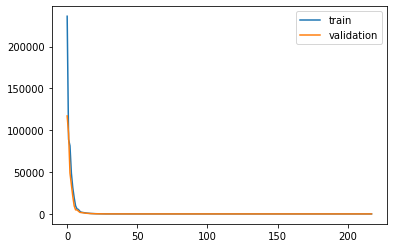

training time = 1633.781168937683 seconds


In [7]:

import time

model = CNN
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

s = time.time()

history = model.fit(x_train,x_train, validation_data=(x_test, x_test), epochs=300, verbose=2, shuffle=False, callbacks = [es])

e = time.time()

# plot history
pyplot.plot(history.history['loss'], label = 'train')
pyplot.plot(history.history['val_loss'], label = 'validation')

pyplot.legend()
pyplot.show()
print(f'training time = {e-s} seconds')

input = Input(shape=(n_timesteps,n_features,n_channels, 1))

    *l1 = Conv3D(filters = 60, kernel_size = (2, 2, 2), activation='relu', padding='same')(input) * these are changed, kernel size and filters
    *l2 = Conv3D(filters = 60, kernel_size = (2, 2, 2), activation='relu', padding='same')(l1)
#l3 = MaxPool3D((2,2,2),padding='valid')(l2)
    *l4 = Conv3D(filters = 60, kernel_size = (2, 2, 2), activation='relu', padding='same')(l2)
    l5 = Conv3D(filters = 1, kernel_size = (2, 2, 2), activation='relu', padding='same')(l4) only change kernel size here
all using nrows = 1000, patience = 10, epochs = 300 

kernel in third dim must be smaller than input to be able to establish correlations in this dim.

loss: 120.9649 - val_loss: 235.5185 for kernel = 3,3,1, 16 filters    
loss: 76.3744 - val_loss: 161.5475 for kernel = 3,3,3, 16 filters  
loss: 6.2998 - val_loss: 7.3455 for kernel = 2, 2, 2, 60 filters  
loss: 24 - val_loss: 21.1457 for kernel = 2, 2, 2, 80 filters  
loss: 3.4384 - val_loss: 4.4540 for kernel = 2, 2, 1, 60 filters
loss: 8.4616 - val_loss: 604.7426 for kernel = 10, 2, 1, 60 filters (training time = 2193.382426261902 seconds) 

using nrows = 10000:
early stopping: Epoch 218/300: loss: 0.7777 - val_loss: 0.7862 (best around epoch 208:loss: 0.4987 - val_loss: 0.4804) for kernel = 2, 2, 1, 60 filters

In [1]:
# from https://keras.io/examples/vision/3D_image_classification/

def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

NameError: name 'keras' is not defined